In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #""      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
dataset_dir = '/kaggle/input/imp-db/IMP_DB_124'

In [3]:
from tensorflow.keras.preprocessing.image import img_to_array,load_img
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
from PIL import Image
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import albumentations as A

2024-08-16 16:51:01.547262: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 16:51:01.547318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 16:51:01.548799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
NIR_Images = []
VIS_Images = []
Labels = []

In [5]:
for i in range(1,63):
    string = f"{i:03}"
    dir1 = dataset_dir+'/NIR/'+string+'_L'
    dir2 = dataset_dir+'/NIR/'+string+'_R'
    for file in os.listdir(dir1):
        img = load_img(os.path.join(dir1,file),target_size =(224,224,3))
        img_array = img_to_array(img)
        NIR_Images.append(img_array)
        Labels.append(2*(i-1))
    for file in os.listdir(dir2):
        img = load_img(os.path.join(dir2,file),target_size =(224,224,3))
        img_array = img_to_array(img)
        NIR_Images.append(img_array)
        Labels.append(2*(i-1)+1)

In [6]:
for i in range(1,63):
    string = f"{i:03}"
    dir1 = dataset_dir+'/VIS/'+string+'_L'
    dir2 = dataset_dir+'/VIS/'+string+'_R'
    for file in os.listdir(dir1):
        img = load_img(os.path.join(dir1,file),target_size =(224,224,3))
        img_array = img_to_array(img)
        VIS_Images.append(img_array)
    for file in os.listdir(dir2):
        img = load_img(os.path.join(dir2,file),target_size =(224,224,3))
        img_array = img_to_array(img)
        VIS_Images.append(img_array)

In [7]:
VIS_Images=np.array(VIS_Images)
NIR_Images=np.array(NIR_Images)

In [8]:
VIS_Images_uint8 = (VIS_Images).astype(np.uint8)
NIR_Images_uint8 = (NIR_Images).astype(np.uint8)

In [9]:
vis_images = np.array([np.array(Image.fromarray(img).resize((112, 112))) for img in VIS_Images_uint8])
nir_images = np.array([np.array(Image.fromarray(img).resize((112, 112))) for img in NIR_Images_uint8])

In [10]:
nir_images[1]

array([[[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [121, 121, 121],
        [119, 119, 119],
        [120, 120, 120]],

       [[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [122, 122, 122],
        [120, 120, 120],
        [121, 121, 121]],

       [[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [123, 123, 123],
        [123, 123, 123],
        [122, 122, 122]],

       ...,

       [[  4,   4,   4],
        [  5,   5,   5],
        [  8,   8,   8],
        ...,
        [ 74,  74,  74],
        [ 75,  75,  75],
        [ 76,  76,  76]],

       [[  4,   4,   4],
        [  5,   5,   5],
        [  7,   7,   7],
        ...,
        [ 73,  73,  73],
        [ 75,  75,  75],
        [ 78,  78,  78]],

       [[  4,   4,   4],
        [  5,   5,   5],
        [  7,   7,   7],
        ...,
        [ 71,  71,  71],
        [ 75,  75,  75],
        [ 78,  78,  78]]

In [11]:
nir_images.shape

(620, 112, 112, 3)

In [12]:
vis_images = (vis_images).astype(np.float32)/255.0
nir_images = (nir_images).astype(np.float32)/255.0

In [13]:
vis_images[1]

array([[[0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        ...,
        [0.69803923, 0.5176471 , 0.42352942],
        [0.69411767, 0.5137255 , 0.41960785],
        [0.6901961 , 0.50980395, 0.41568628]],

       [[0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        ...,
        [0.7019608 , 0.52156866, 0.42745098],
        [0.69803923, 0.5176471 , 0.42352942],
        [0.6901961 , 0.50980395, 0.41568628]],

       [[0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        [0.02352941, 0.02352941, 0.02352941],
        ...,
        [0.7019608 , 0.52156866, 0.42745098],
        [0.7019608 , 0.52156866, 0.42745098],
        [0.69411767, 0.5137255 , 0.41960785]],

       ...,

       [[0.4627451 , 0.31764707, 0.21568628],
        [0.4745098 , 0.3254902 , 0.22745098],
        [0.5019608 , 0

In [14]:
labels=np.array(Labels)

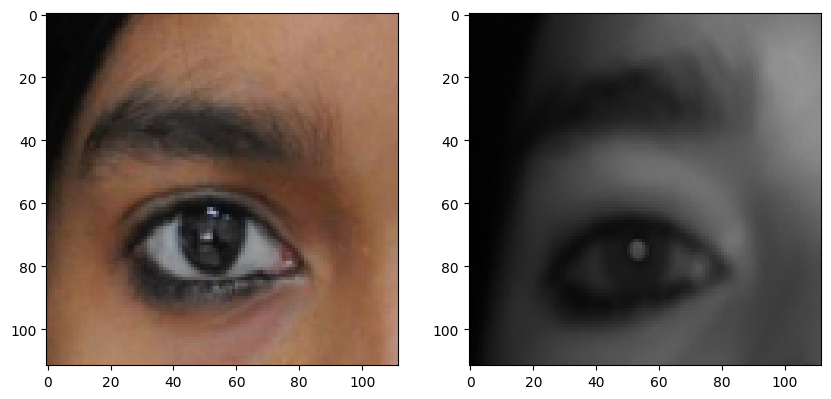

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(vis_images[1])
plt.subplot(1,2,2)
plt.imshow(nir_images[1])
plt.show()

In [16]:
print(vis_images.shape)
print(nir_images.shape)
print(labels.shape)

(620, 112, 112, 3)
(620, 112, 112, 3)
(620,)


In [17]:
genuine_pairs=[]
pair_labels=[]

In [18]:
unique_classes = np.unique(Labels)
print(unique_classes)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123]


In [19]:
for class_label in unique_classes:
    vis_indices = np.where(Labels == class_label)[0]
    nir_indices = np.where(Labels == class_label)[0]
    
    for vis_idx in vis_indices:
        for nir_idx in nir_indices:
            vis_image_ = vis_images[vis_idx]
            nir_image_ = nir_images[nir_idx]
            genuine_pairs.append((vis_image_, nir_image_))
            pair_labels.append(1) 

In [20]:
genuine_pairs = np.array(genuine_pairs)
pair_labels = np.array(pair_labels)

In [21]:
genuine_pairs.shape

(3100, 2, 112, 112, 3)

In [22]:
pair_labels.shape

(3100,)

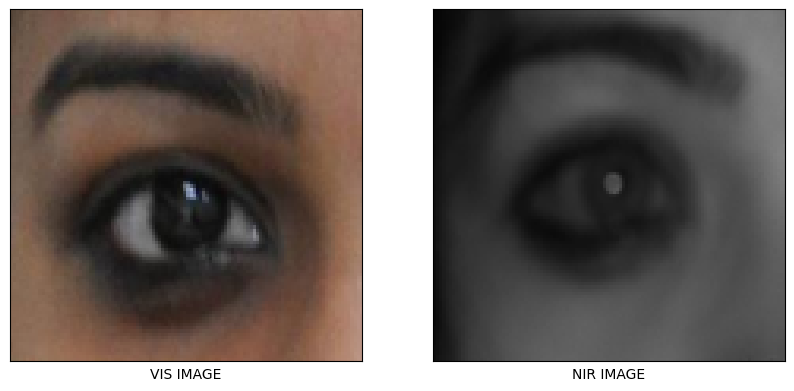

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(genuine_pairs[100][0])
plt.xlabel("VIS IMAGE")
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(genuine_pairs[100][1])
plt.xlabel("NIR IMAGE")
plt.xticks([])
plt.yticks([])
plt.show()

In [24]:
num_genuine_pairs = len(genuine_pairs)
print(num_genuine_pairs)

3100


In [25]:
imposter_pairs = []
np.random.seed(42)

In [26]:
while len(imposter_pairs) < num_genuine_pairs:
    vis_idx = np.random.randint(0, 620)
    nir_idx = np.random.randint(0, 620)
    
    if labels[vis_idx] != labels[nir_idx]:
        vis_image_ = vis_images[vis_idx]
        nir_image_ = nir_images[nir_idx]
        
        imposter_pairs.append((vis_image_, nir_image_))
        pair_labels = np.append(pair_labels, 0)

In [27]:
len(imposter_pairs)

3100

In [28]:
imposter_pairs = np.array(imposter_pairs)
pairs = np.concatenate((genuine_pairs, imposter_pairs), axis=0)
pair_labels = np.array(pair_labels)

In [29]:
print(pairs.shape)
print(pair_labels.shape)
print(pair_labels)

(6200, 2, 112, 112, 3)
(6200,)
[1 1 1 ... 0 0 0]


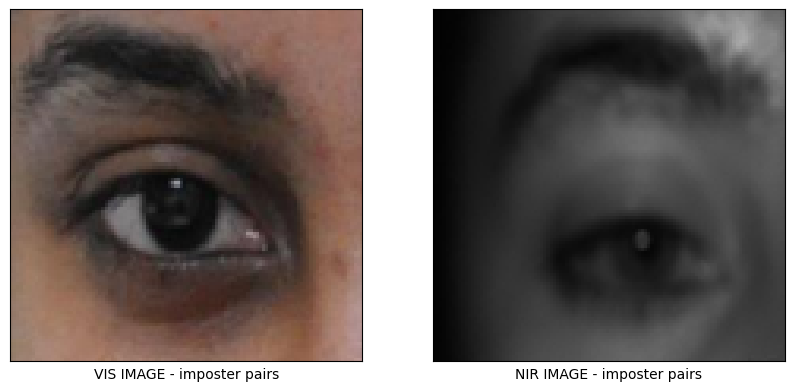

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(pairs[2500][0])
plt.xlabel("VIS IMAGE - imposter pairs")
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(pairs[2500][1])
plt.xlabel("NIR IMAGE - imposter pairs")
plt.xticks([])
plt.yticks([])
plt.show()

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
#train_ratio = 0.6
#val_ratio = 0.2
#test_ratio = 0.2

In [33]:
pairs_train, pairs_temp, labels_train, labels_temp = train_test_split(pairs, pair_labels, test_size=0.4, random_state=42, stratify=pair_labels)
pairs_val, pairs_test, labels_val, labels_test = train_test_split(pairs_temp, labels_temp, test_size=0.5, random_state=42,stratify=labels_temp)

In [34]:
print(f'Training set shape: {pairs_train.shape}')
print(f'Validation set shape: {pairs_val.shape}')
print(f'Test set shape: {pairs_test.shape}')

Training set shape: (3720, 2, 112, 112, 3)
Validation set shape: (1240, 2, 112, 112, 3)
Test set shape: (1240, 2, 112, 112, 3)


In [35]:
transforms = A.Compose([
    A.Rotate(limit=40),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.HorizontalFlip(),
])

In [36]:
def augment_pair(image1, image2):
    augmented1 = transforms(image=image1)['image']
    augmented2 = transforms(image=image2)['image']
    return augmented1, augmented2

In [37]:
def augment_pairs(pairs, labels):
    augmented_pairs = []
    augmented_labels = []
    
    for i, pair in enumerate(pairs):
        image1, image2 = augment_pair(pair[0], pair[1])
        augmented_pairs.append((image1, image2))
        augmented_labels.append(labels[i]) 
    
    return np.array(augmented_pairs), np.array(augmented_labels)

In [38]:
augmented_pairs_train, augmented_labels_train = augment_pairs(pairs_train, labels_train)

In [39]:
pairs_train = np.concatenate([pairs_train, augmented_pairs_train], axis=0)
labels_train = np.concatenate([labels_train, augmented_labels_train], axis=0)

In [40]:
print("Augmented pairs train shape:", augmented_pairs_train.shape)
print("Combined pairs train shape:", pairs_train.shape)

Augmented pairs train shape: (3720, 2, 112, 112, 3)
Combined pairs train shape: (7440, 2, 112, 112, 3)


In [41]:
labels_train.shape

(7440,)

In [42]:
labels_val.shape

(1240,)

In [43]:
labels_train = to_categorical(labels_train, num_classes=2)
labels_val = to_categorical(labels_val, num_classes=2)
labels_test = to_categorical(labels_test, num_classes=2)

In [44]:
labels_test

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [45]:
def create_base_network(input_shape):
    base_model = VGG16(weights ='imagenet',include_top = False,input_shape=input_shape)
    #for layer in base_model.layers:
    #    layer.trainable = True
    x = base_model.output
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096,activation = 'relu')(x)
    x = layers.Dense(4096, activation='relu')(x)
    return Model(base_model.input, x)

In [46]:
input_shape = (112, 112, 3)

In [47]:
base_network = create_base_network(input_shape)
input_a = layers.Input(shape=input_shape)
input_b = layers.Input(shape=input_shape)
processed_a = base_network(input_a)
processed_b = base_network(input_b)

l1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([processed_a, processed_b])

output = layers.Dense(2, activation='softmax')(l1_distance) 

In [48]:
model = Model([input_a, input_b], output)

In [49]:
optimizer = SGD(learning_rate=0.001, momentum=0.9)

In [50]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [51]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 4096)      │ 33,597,248 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4096)      │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │      8,194 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,605,442 (128.19 MB)

 Trainable params: 33,605,442 (128.19 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [53]:
history = model.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_val[:, 0], pairs_val[:, 1]], labels_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/200


I0000 00:00:1723827114.225642     812 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723827114.254483     812 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5402 - loss: 0.6852

W0000 00:00:1723827182.580902     813 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723827184.693983     812 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


233/233 ━━━━━━━━━━━━━━━━━━━━ 108s 347ms/step - accuracy: 0.5403 - loss: 0.6851 - val_accuracy: 0.7177 - val_loss: 0.5689
Epoch 2/200
233/233 ━━━━━━━━━━━━━━━━━━━━ 56s 239ms/step - accuracy: 0.6185 - loss: 0.6391 - val_accuracy: 0.7581 - val_loss: 0.4918
Epoch 3/200
233/233 ━━━━━━━━━━━━━━━━━━━━ 55s 238ms/step - accuracy: 0.6338 - loss: 0.6214 - val_accuracy: 0.8024 - val_loss: 0.4515
Epoch 4/200
233/233 ━━━━━━━━━━━━━━━━━━━━ 56s 239ms/step - accuracy: 0.6961 - loss: 0.5663 - val_accuracy: 0.8766 - val_loss: 0.3694
Epoch 5/200
233/233 ━━━━━━━━━━━━━━━━━━━━ 56s 239ms/step - accuracy: 0.7277 - loss: 0.5110 - val_accuracy: 0.8927 - val_loss: 0.3120
Epoch 6/200
233/233 ━━━━━━━━━━━━━━━━━━━━ 55s 238ms/step - accuracy: 0.7420 - loss: 0.4748 - val_accuracy: 0.8903 - val_loss: 0.2786
Epoch 7/200
233/233 ━━━━━━━━━━━━━━━━━━━━ 55s 238ms/step - accuracy: 0.7657 - loss: 0.4349 - val_accuracy: 0.9218 - val_loss: 0.2354
Epoch 8/200
233/233 ━━━━━━━━━━━━━━━━━━━━ 55s 238ms/step - accuracy: 0.7837 - loss: 0.40

In [54]:
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

test_loss, test_acc = model.evaluate([pairs_test[:, 0], pairs_test[:, 1]], labels_test)

print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Train Loss: {train_loss:.4f}") 
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}") 
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9563 - loss: 0.1272
Train Accuracy: 92.92%
Train Loss: 0.1382
Validation Accuracy: 95.40%
Validation Loss: 0.1473
Test Accuracy: 95.40%
Test Loss: 0.1331


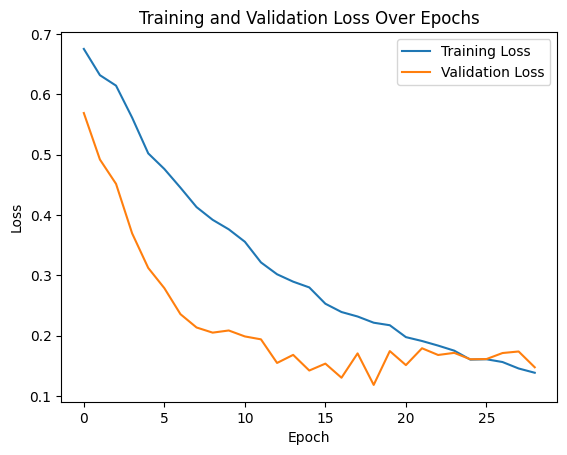

In [55]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

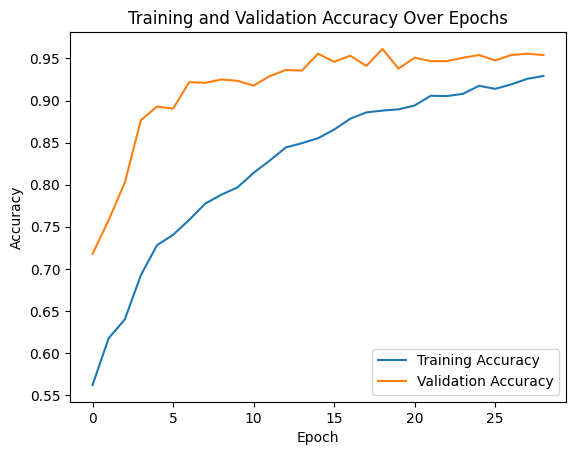

In [56]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [57]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [58]:
predictions = model.predict([pairs_test[:, 0], pairs_test[:, 1]])

 3/39 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step 

W0000 00:00:1723828810.811855     814 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step


In [59]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test, axis=1)

In [60]:
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')

In [61]:
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Precision: 0.96
Recall: 0.95


In [62]:
true_labels_binary = np.argmax(labels_test, axis=1)
predicted_probs = predictions[:, 1]

In [63]:
roc_auc = roc_auc_score(true_labels_binary, predicted_probs)

In [64]:
fpr, tpr, thresholds = roc_curve(true_labels_binary, predicted_probs)
roc_auc_value = auc(fpr, tpr)

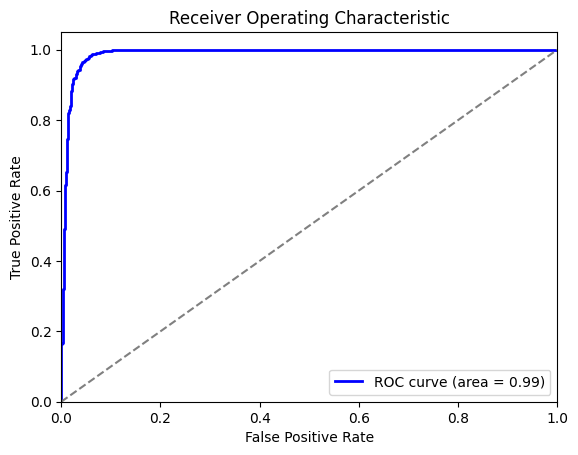

In [65]:
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [66]:
print(f'ROC AUC: {roc_auc:.2f}')

ROC AUC: 0.99


In [67]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])

<Figure size 800x600 with 0 Axes>

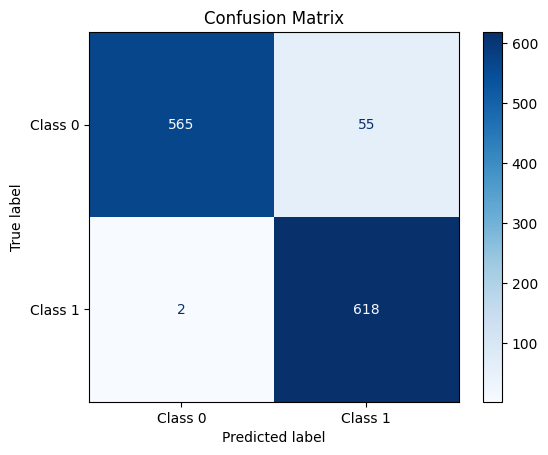

In [68]:
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

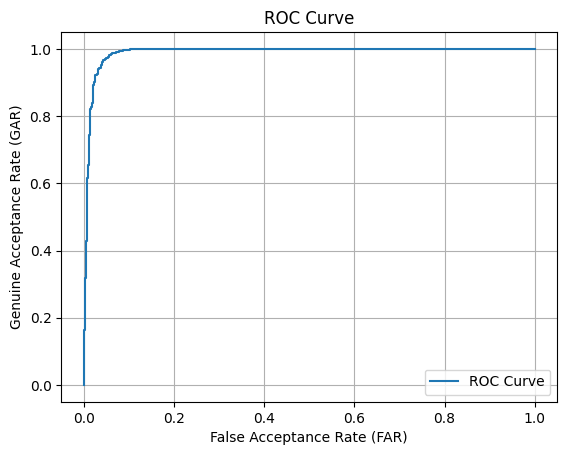

In [69]:
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Acceptance Rate (FAR)')
plt.ylabel('Genuine Acceptance Rate (GAR)')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [70]:
frr = 1 - tpr
diff = np.abs(fpr - frr)
ind = np.argmin(diff)
eer = (fpr[ind] + frr[ind]) / 2
eer_percentage = eer * 100
print(f'EER: {eer_percentage:.2f}%')

EER: 4.03%


In [71]:
far_value = 0.1

In [72]:
def linear_interpolation(x, x_points, y_points):
    
    idx = np.searchsorted(x_points, x)
    idx = np.clip(idx, 1, len(x_points) - 1) 
    
    x0, x1 = x_points[idx - 1], x_points[idx]
    y0, y1 = y_points[idx - 1], y_points[idx]
    
    # Linear interpolation formula
    return y0 + (y1 - y0) * (x - x0) / (x1 - x0)

In [73]:
gar_at_far = linear_interpolation(far_value, fpr, tpr)
gar_percentage = gar_at_far * 100
print(f'GAR at FAR = {far_value}: {gar_percentage:.2f}%')

GAR at FAR = 0.1: 99.68%
